In [1]:
import sys
import glob

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cmocean
import numpy as np

sys.path.append('/g/data/xv83/quantile-mapping/qqscale')
import utils

In [2]:
barra_files = sorted(glob.glob("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/pr/v20240809/pr_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc"))
ds_barra = utils.read_data(
    barra_files,
    'pr',
    time_bounds=['1985', '2014'],
    input_units="kg m-2 s-1",
    output_units="mm day-1",
)
try:
    ds_barra = ds_barra.drop_vars('crs')
except ValueError:
    pass
da_barra_annual = ds_barra['pr'].resample(time='Y').sum(dim='time', keep_attrs=True)
da_barra_annual_clim = da_barra_annual.mean('time')
da_barra_annual_clim = da_barra_annual_clim.compute()

In [4]:
agcd_files = sorted(glob.glob("/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_*_daily.nc"))
ds_agcd = utils.read_data(
    agcd_files,
    'precip',
    time_bounds=['1985', '2014'],
    input_units="mm day-1",
    output_units="mm day-1",
)
try:
    ds_agcd = ds_agcd.drop_vars('crs')
except ValueError:
    pass
da_agcd_annual = ds_agcd['precip'].resample(time='Y').sum(dim='time', keep_attrs=True)
da_agcd_annual_clim = da_agcd_annual.mean('time')
da_agcd_annual_clim = da_agcd_annual_clim.compute()

In [6]:
city_lat_lon = {
    'Hobart': (-42.9, 147.3),
    'Melbourne': (-37.8, 145.0),
    'Mildura': (-34.2, 142.1),
#    'Thredbo': (-36.5, 148.3),
    'Sydney': (-33.9, 151.2),
    'Brisbane': (-27.5, 153.0),
    'Cairns': (-16.9, 145.8),
    'Mount Isa': (-20.8, 139.5), 
    'Darwin': (-12.5, 130.8),
    'Alice Springs': (-23.7, 133.9),
    'Port Hedland': (-20.3, 118.6),
    'Perth': (-32.0, 115.9),
    'Adelaide': (-34.9, 138.6),
}

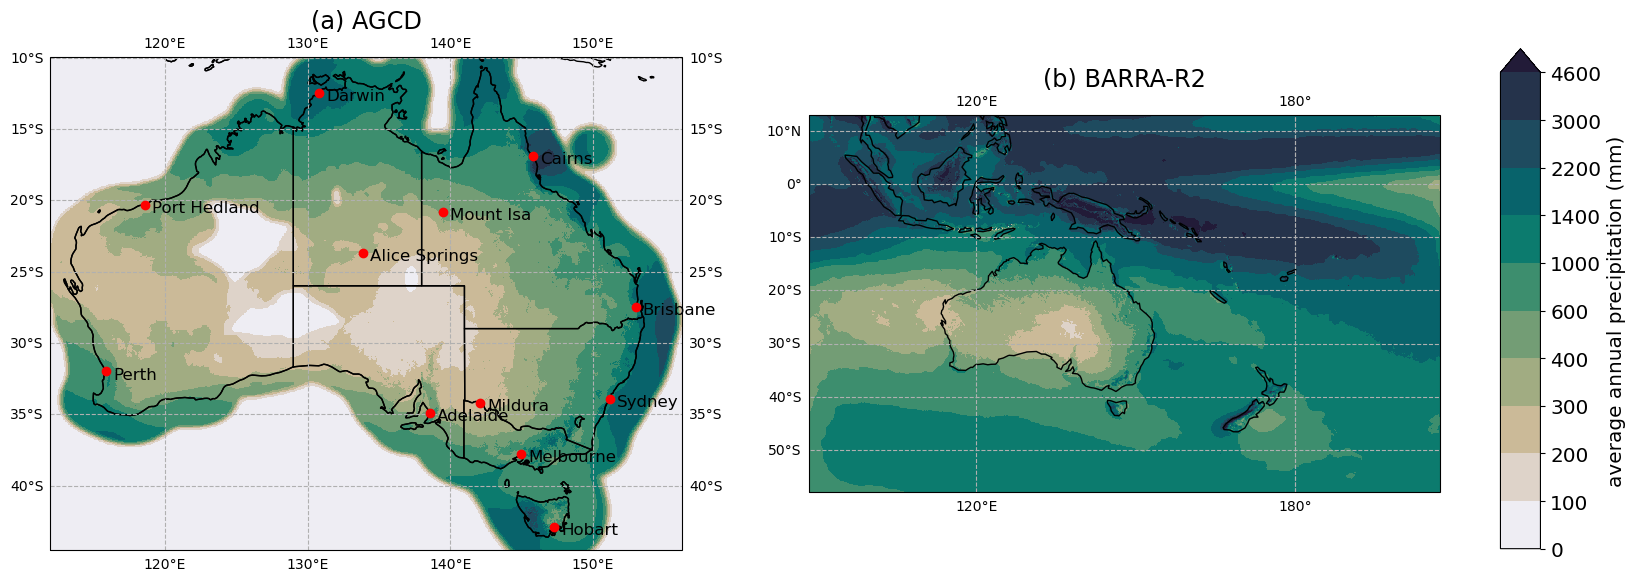

In [9]:
fig = plt.figure(figsize=[20, 10])
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))

cmap = cmocean.cm.rain
levels = [0, 100, 200, 300, 400, 600, 1000, 1400, 2200, 3000, 4600]

da_agcd_annual_clim.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels,
    extend='max',
    add_colorbar=False,
)
ax1.coastlines()
ax1.add_feature(cartopy.feature.STATES)
ax1.gridlines(linestyle='--', draw_labels=True)
ax1.set_title('(a) AGCD', size='xx-large')

for city in city_lat_lon:
    lat, lon = city_lat_lon[city]
    ax1.plot(lon, lat, 'ro', zorder=5, transform=ccrs.PlateCarree())
    ax1.text(
        lon + 0.5,
        lat - 0.5,
        city,
        fontsize='large',
        transform=ccrs.PlateCarree()
    )

im = da_barra_annual_clim.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels,
    extend='max',
    add_colorbar=False,
)
ax2.coastlines()
ax2.add_feature(cartopy.feature.STATES)
ax2.gridlines(linestyle='--', draw_labels=True)
ax2.set_title('(b) BARRA-R2', size='xx-large')

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize='x-large')
cbar.set_ticks(ticks=levels, labels=levels)
cbar.set_label('average annual precipitation (mm)', size='x-large')

plt.savefig(
    f'pr_annual-mean_AGCD_BARRA-R2_1985-2014.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300
)
plt.show()